In [1]:
%matplotlib inline

In [2]:
### Standard Libraries -----------------------------------------------
import numpy as np
import pandas as pd
import seaborn as sns
import os
import bilby.gw.conversion as conversion
import matplotlib.pyplot as plt
import copy
from  scipy.special import logsumexp, rel_entr
import seaborn as sns
import h5py
import bilby

### Non-standard Libararies -------------------------------------------
import lwp
import lwp.executables.get_files as get_files

from lwp import executables

# Set to true the first time this is run, 
# can be turned off later to save time/bandwidth
download_astro_samples = False
download_eos_samples = False

/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
### Unit conversion
gcm3_to_dynecm2=8.9875e20 
MeV_to_gcm3 = 1.7827e12 
dynecm2_to_MeVFermi = 1.6022e33
gcm3_to_fm4 = 3.5178e14
sat_dens = 2.8*(np.power(10.0,14.))
c = bilby.core.utils.speed_of_light

In [4]:
# Download Astrophysical samples and compute the bandwidth for the samples.
# We also get the chirp-mass range and mass-ratio range of the samples, so we can 
# make sure the prior we set is not smaller than the support of the likelihood.
# You can specify a "load_function" which helps the code translate the input format
# given to the common lwp table-column format.  This must be done for public h5 samples
# because of the degeneracy with bilby-format .h5 result files. See `lwp/utils/io.py` 
# for a list of possible load functions. 
# This will also save the samples and .in file by default.

if download_astro_samples:
    astro_data_and_metadata = executables.get_files.get_astro_samples(
    "bilby_results_files_v1.zip", 
    "PE170817_low_spin.csv", 
    download_url="https://dcc.ligo.org/public/0168/P2000193/002/bilby_results_files_v1.zip",
    max_num_pe_samples = 3000,
    load_samples_kwargs = {"load_function": None, "low_spin":True})
    
    # Get the data we need to run lwp_pipe
    astro_prefix= "PE170817_low_spin"
    astro_data = astro_data_and_metadata["data"]
    bandwidth = astro_data_and_metadata["bandwidth"]
    chirp_mass_range = np.array(astro_data_and_metadata["mc_range"].iloc[0,:])

In [5]:
# If the samples are already on disk, no need to download them again,
# we can just read the bandwidth out of the saved file
# (If the samples are already on disk but the .in file doesn't exist, no worries! just 
# call the function above `get_astro_samples` with `download_url` set to `None`, and no 
# extra downloading will be done.)

astro_prefix= "PE170817_low_spin"
if not(download_astro_samples):
    astro_data_and_metadata = executables.get_files.get_astro_samples(
    "gw_events/GW170817_IMRPhenomPv2_NRTidal_lowspin_0_result.json", ### input here, name of desired file to read in
    f"{astro_prefix}.csv", 
    download_url = None, # No download needed 
    max_num_pe_samples = 5000,
    scan_likelihood = False, # Assume the .in file is stored
    load_samples_kwargs = {}) # The correct loading function will be called on already-processed .csv's
    
    # Get the data we need to run lwp_pipe
    
    astro_data = astro_data_and_metadata["data"]
    bandwidth = astro_data_and_metadata["bandwidth"]
    chirp_mass_range = np.array(astro_data_and_metadata["mc_range"].iloc[0,:])

successfully got 53609 pe samples,
downsampling to 5000 samples


In [6]:
# Download an example set of EoS's to be used by the LVK in O4
if download_eos_samples:
    samples_url = "https://zenodo.org/record/6502467/files/LCEHL_EOS_posterior_samples_PSR.h5?download=1"
    samples_file =  "LCEHL_EOS_posterior_samples_PSR.h5"
    !curl {samples_url} -o {samples_file}


In [7]:
# This code defines the needed map from eos-indices to macroscopic m-lambda
# relations.  It also defines which EoS to be used by specifying which integers
# `eos_to_be_used` should be used as keys to the `macro_data` mapping
# For a better resolved run, simply use more EoSs e.g. `eos_to_be_used = np.arange(10000)`.
# You can also use your own EoS set by just creating a `macro_data`
# which maps integers to your M-Lambda curves 
# e.g. macro_data = {eos_num : pd.read_csv(f"my_m_lambda_curve_{eos_num}.csv")}
# just make sure the columns  "M", "Lambda" appear.  

samples_file =  "LCEHL_EOS_posterior_samples_PSR.h5"
samples_tag = "np"
samples  = h5py.File(samples_file)

eos_to_be_used = np.arange(10000)

### Enumerating Mass-Radius EoS Relation values
macro_data = {eos_num: np.array(samples['ns'][eos_id]) for eos_num, eos_id in enumerate(samples['eos'])}
### Enumerating Pressure-Density Relations for likelihood weighing
macro_data2 = {eos_num2 : np.array(samples['eos'][eos_id]) for eos_num2, eos_id in enumerate(samples['eos'])}

In [ ]:
# Compute the likelihoods and marginal likelihoods.
# This is the primary executable of lwp, it computes the likelihoods of each EoS 

result = executables.lwp_pipe(
    eos_indices = np.array(eos_to_be_used),
    retrieve_macro_data = lambda index: macro_data[index], 
    gw_posterior_samples = astro_data,
    likelihood_bandwidth=bandwidth,
    likelihood_prior_key="gauss_mc_flat_q",
    mc_marginalization_range=chirp_mass_range,
    save_likelihoods=f"./{astro_prefix}_post.csv",
    save_marginalized_likelihoods=f"./{astro_prefix}_eos.csv")

In [ ]:
# This is, for example, all of the likelihood evaluations L(m1, m2, Lambda(m1, EoS), Lambda(m2, EoS), EoS)
likelihoods= result["likelihood_evaluations"]
likelihoods

In [ ]:
# The result dictionary stores the results and marginalization parameters
result.keys()

***
## Importing Marginalized Likelihoods (Post-LWP-run)

In [9]:
lwp_run = True
verbose = True
gw_event = "GW170817"
eos_set = "GP"

if lwp_run == True: ### To load weights from a condor-submitted LWP job
    weights = pd.read_csv(f"{gw_event}_{eos_set}_lwp/result/{gw_event}_{eos_set}_lwp_eos.csv")
elif lwp_run != True: ### To load weights from notebook analysis runs
    weights = pd.read_csv(f"{astro_prefix}_eos.csv") 
    if verbose == True:
        print(f"Loading weights for event: {astro_prefix}")
        
max_logweight = max(weights['logmargweight'])

## EoS Likelihood Distribution

/tmp/ipykernel_1515828/2312932845.py:5: RuntimeWarning: overflow encountered in exp
  alpha = .15*(.1 + (.5*(1/(1 + np.exp(-(weights['logmargweight'][i] - max_logweight))))))


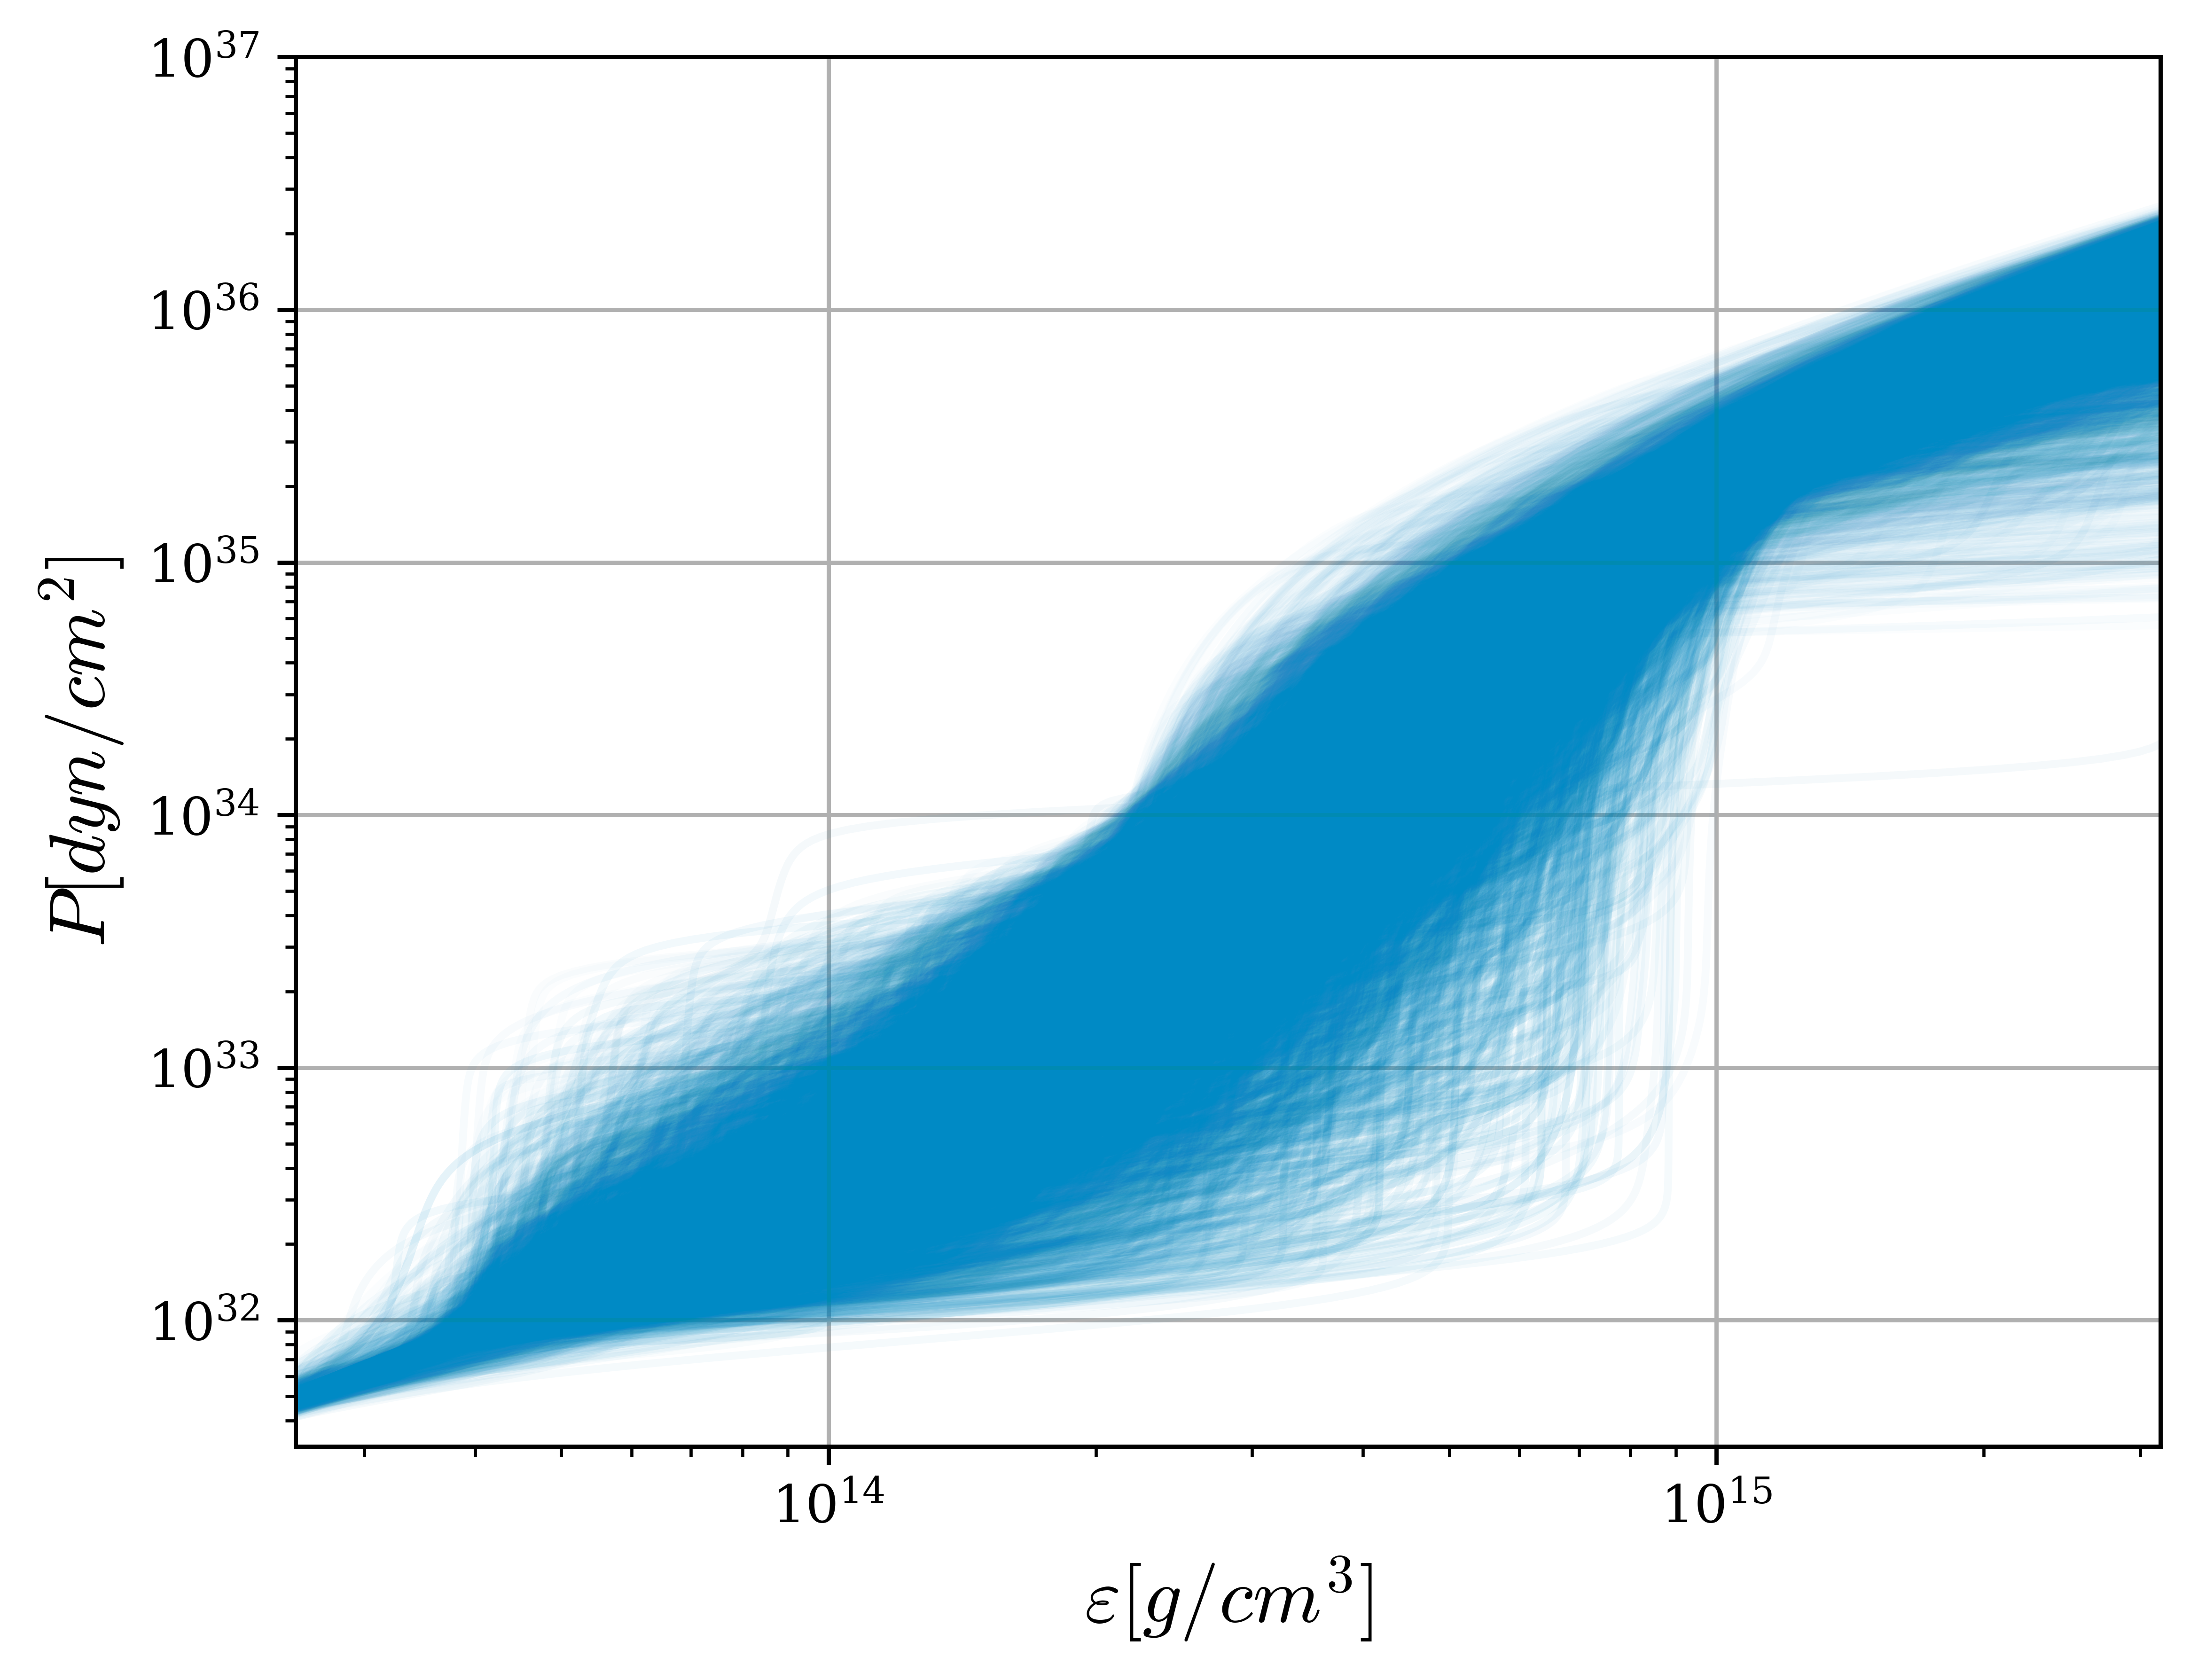

In [13]:
for i in range(len(weights['logmargweight'])):
    eos_number = eos_to_be_used[i]
    plt.loglog(macro_data2[eos_number]['energy_densityc2'], macro_data2[eos_number]['pressurec2']*gcm3_to_dynecm2,
             color = "#008ac5",
             alpha = .15*(.1 + (.5*(1/(1 + np.exp(-(weights['logmargweight'][i] - max_logweight)))))) 
             #alpha = np.exp(likelihoods["logmargweight"][i])/np.sum(np.exp(likelihoods["logmargweight"]))
            )
    
plt.xlabel(r"$\varepsilon  [g/cm^3]$", math_fontfamily = "cm", fontsize = 15.)
plt.ylabel(r"$P  [dyn/cm^2]$", math_fontfamily = "cm", fontsize = 15.)

xmin = np.power(10.0,13.4)
xmax = np.power(10.0,15.5)
ymin = np.power(10.0,31.5)
ymax = np.power(10.0,37.0)

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.grid()
plt.gcf().set_dpi(800)

plt.show()

***
## Sound Speed related functions:
#### For a system at zero temperature. ($\mu_{B} = h$)

In [9]:
def chem_potent(p, epsilon, baryon): ### Chemical Potential Calculation, defined via Enthalpy at zero temperature
    mu = ((p + epsilon)/baryon)
    return mu

def trace_anom(pressure, density): ### Trace Anomaly calculation
    trace_anomaly = (1./3.) - (pressure/density)
    return trace_anomaly

***

### Only need draw EoS's from posterior distribution once:

In [10]:
try:
    # Resampling EoS's with weighted values according to lwp likelihoods
    ex_weights = np.exp(weights["logmargweight"])
    # Normalize values to have probabilities add up to 1
    ex_weights = ex_weights/(sum(ex_weights))
    # Resample EoS's according to weights --> gives posterior distribution of EoS's
    weight_eos = np.random.choice(eos_to_be_used, size=20000, replace=True, p=ex_weights)
    
except ValueError:
    try:
        print("Fixing NaN values...")
        # Fixing any NaN values in logmargweight ####################################
        fixed_weights = weights[weights.isna().any(axis=1)]
        # Might need to change this to account for all indices of NaN (?)
        weights.loc[fixed_weights.index,["logmargweight","logvarmargweight"]] = -np.inf
        ###############################################################################
        
        # Try resampling one more time
        ex_weights = np.exp(weights["logmargweight"])
        ex_weights = ex_weights/(sum(ex_weights))
        weight_eos = np.random.choice(eos_to_be_used, size=20000, replace=True, p=ex_weights)
        
    except ValueError:
        print("All EoS's are unlikely.")

### Posterior Plotting: Using geometric spacing for the density grid

In [11]:
plot_densities = np.geomspace(np.power(10.0,13.0), np.power(10.0,16.0), 5000)
percentiles = [5,95]

### Pressure - Density Posterior Generation:

In [12]:
pevals = []
w_pevals = []
for eos in range(len(eos_to_be_used)):
    eos_densities = macro_data2[eos]["energy_densityc2"]
    eos_pressures = macro_data2[eos]["pressurec2"]*gcm3_to_dynecm2
    pevals.append(np.interp(plot_densities, eos_densities, eos_pressures))
pevals = np.array(pevals)

for eos in weight_eos:
    eos_densities = macro_data2[eos]["energy_densityc2"]
    eos_pressures = macro_data2[eos]['pressurec2']*gcm3_to_dynecm2
    w_pevals.append(np.interp(plot_densities, eos_densities, eos_pressures))
w_pevals = np.array(w_pevals)

### Obtaining quantiles 
p_sigmas = np.zeros((len(plot_densities),len(percentiles)))
p_w_sigmas = np.zeros((len(plot_densities),len(percentiles)))
for i in range(len(plot_densities)):
    p_sigmas[i]=np.percentile(np.array(pevals[:,i]),percentiles)
    p_w_sigmas[i]=np.percentile(np.array(w_pevals[:,i]),percentiles)

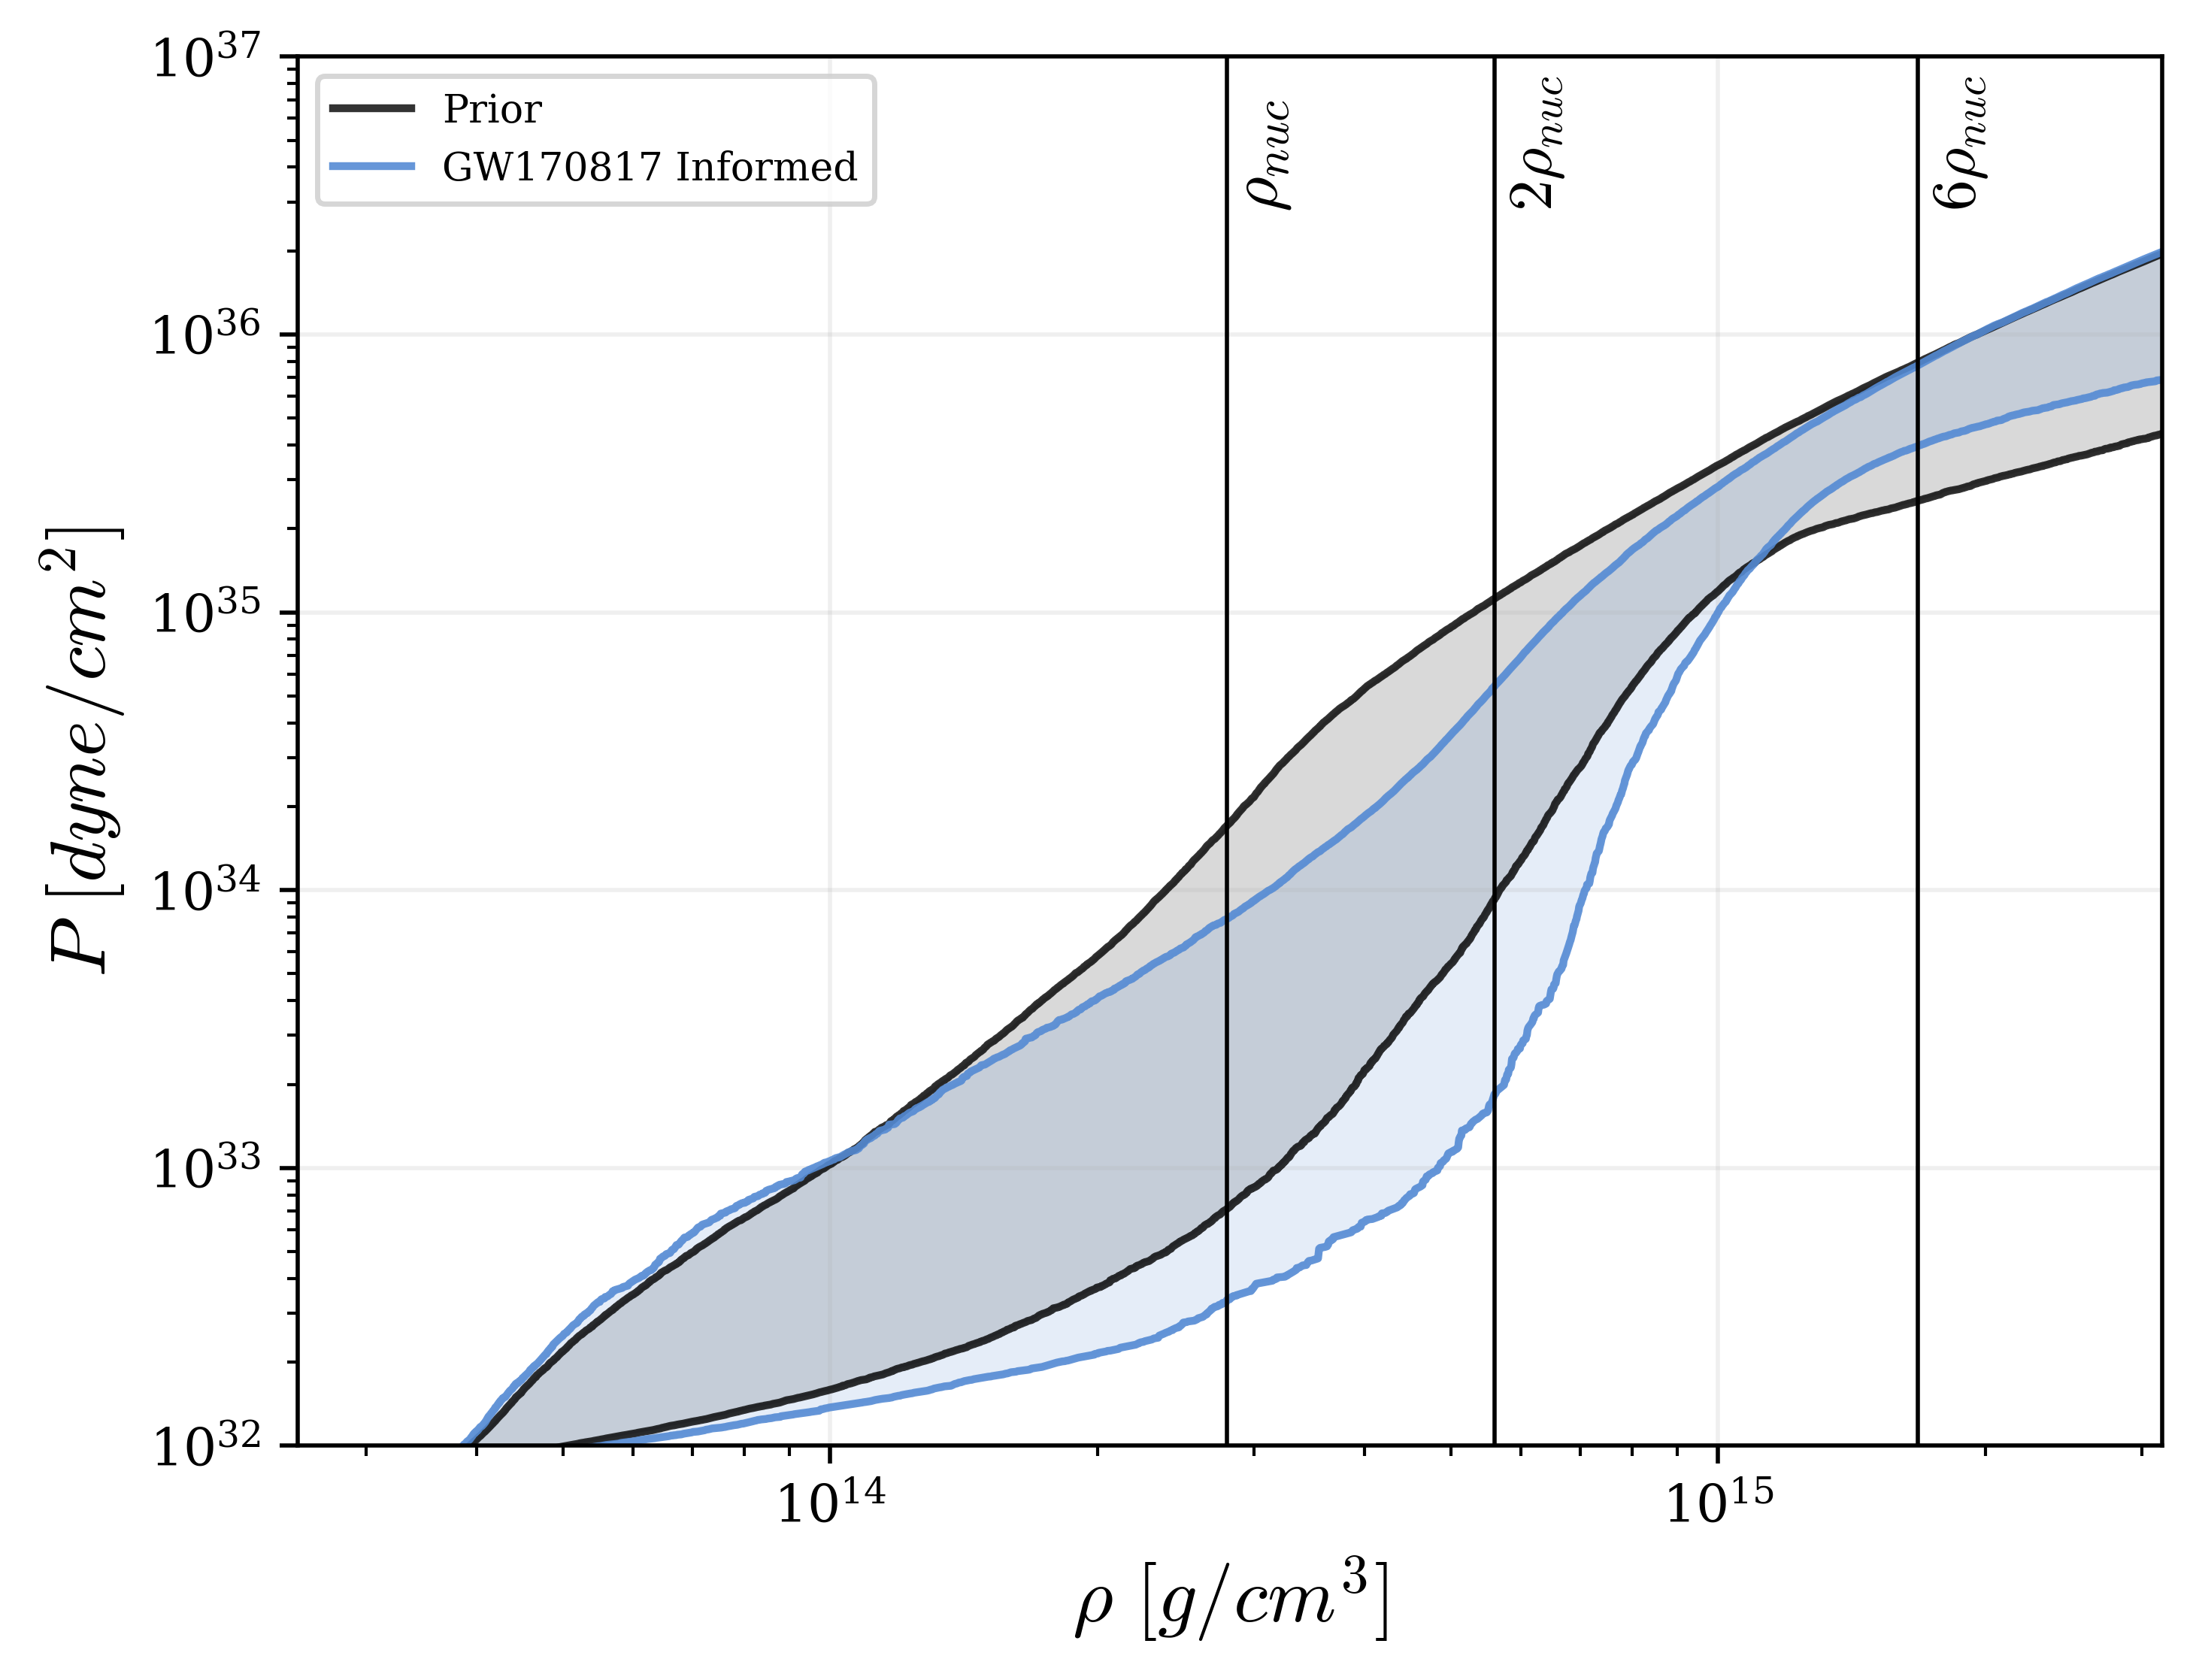

In [14]:
plt.loglog()

plt.plot(plot_densities,p_sigmas[:,0], color = "k", alpha = .8, label = "Prior") 
plt.plot(plot_densities,p_sigmas[:,1], color = "k", alpha = .8)
plt.plot(plot_densities,p_w_sigmas[:,0], color = "#558BD4", alpha = .9, label = "GW170817 Informed") 
plt.plot(plot_densities,p_w_sigmas[:,1], color = "#558BD4", alpha = .9)
plt.fill_between(plot_densities,p_sigmas[:,0], p_sigmas[:,1], alpha = 0.15, color = "k")
plt.fill_between(plot_densities,p_w_sigmas[:,0], p_w_sigmas[:,1], alpha = 0.15, color = "#558BD4")

plt.xlabel(r"$\rho \ [g/cm^3]$", math_fontfamily = "cm", fontsize = 15.)
plt.ylabel(r"$P \ [dyne/cm^2]$", math_fontfamily="cm", fontsize = 15.)

xmin = np.power(10.0,13.4)
xmax = np.power(10.0,15.5)
ymin = np.power(10.0,32.)
ymax = np.power(10.0,37.0)

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.grid(alpha = 0.2)

plt.axvline(x = sat_dens, color = "k", linewidth = .8)
plt.axvline(x = 2*sat_dens, color = "k", linewidth = .8)
plt.axvline(x = 6*sat_dens, color = "k", linewidth = .8)

plt.annotate(r"$\rho_{nuc}$",xy = ((sat_dens), (np.power(10.,36.5))),
             rotation = 90.0, math_fontfamily = "cm", fontsize = 13.)
plt.annotate(r"$2\rho_{nuc}$",xy = ((2*sat_dens)*(np.power(10.0,.012)), (np.power(10.,36.5))),
             rotation = 90.0, math_fontfamily = "cm", fontsize = 12.)
plt.annotate(r"$6\rho_{nuc}$",xy = ((6*sat_dens)*(np.power(10.0,.012)),(np.power(10.,36.5))),
             rotation = 90.0, math_fontfamily = "cm", fontsize = 12.)

plt.legend(fontsize = 7.5)
plt.gcf().set_dpi(500)
plt.show()


****
### Sound Speed Posterior Generation:

In [15]:
csvals = []
w_csvals = []
for eos in range(len(eos_to_be_used)):
    eos_densities = macro_data2[eos]["energy_densityc2"]
    eos_cs = np.gradient((macro_data2[eos]['pressurec2']), macro_data2[eos]["energy_densityc2"])
    csvals.append(np.interp(plot_densities, eos_densities, eos_cs))
csvals = np.array(csvals)

for eos in weight_eos:
    eos_densities = macro_data2[eos]["energy_densityc2"]
    eos_cs = np.gradient((macro_data2[eos]['pressurec2']), macro_data2[eos]["energy_densityc2"])
    w_csvals.append(np.interp(plot_densities, eos_densities, eos_cs))
w_csvals = np.array(w_csvals)

### Obtaining quantiles 
sigmas = np.zeros((len(plot_densities),len(percentiles)))
w_sigmas = np.zeros((len(plot_densities),len(percentiles)))
for i in range(len(plot_densities)):
    sigmas[i]=np.percentile(np.array(csvals[:,i]),percentiles)
    w_sigmas[i]=np.percentile(np.array(w_csvals[:,i]),percentiles)

/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/numpy/lib/function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/numpy/lib/function_base.py:1240: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/numpy/lib/function_base.py:1241: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/numpy/lib/function_base.py:1241: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/cvmfs/software.igwn.org/conda/envs/igwn

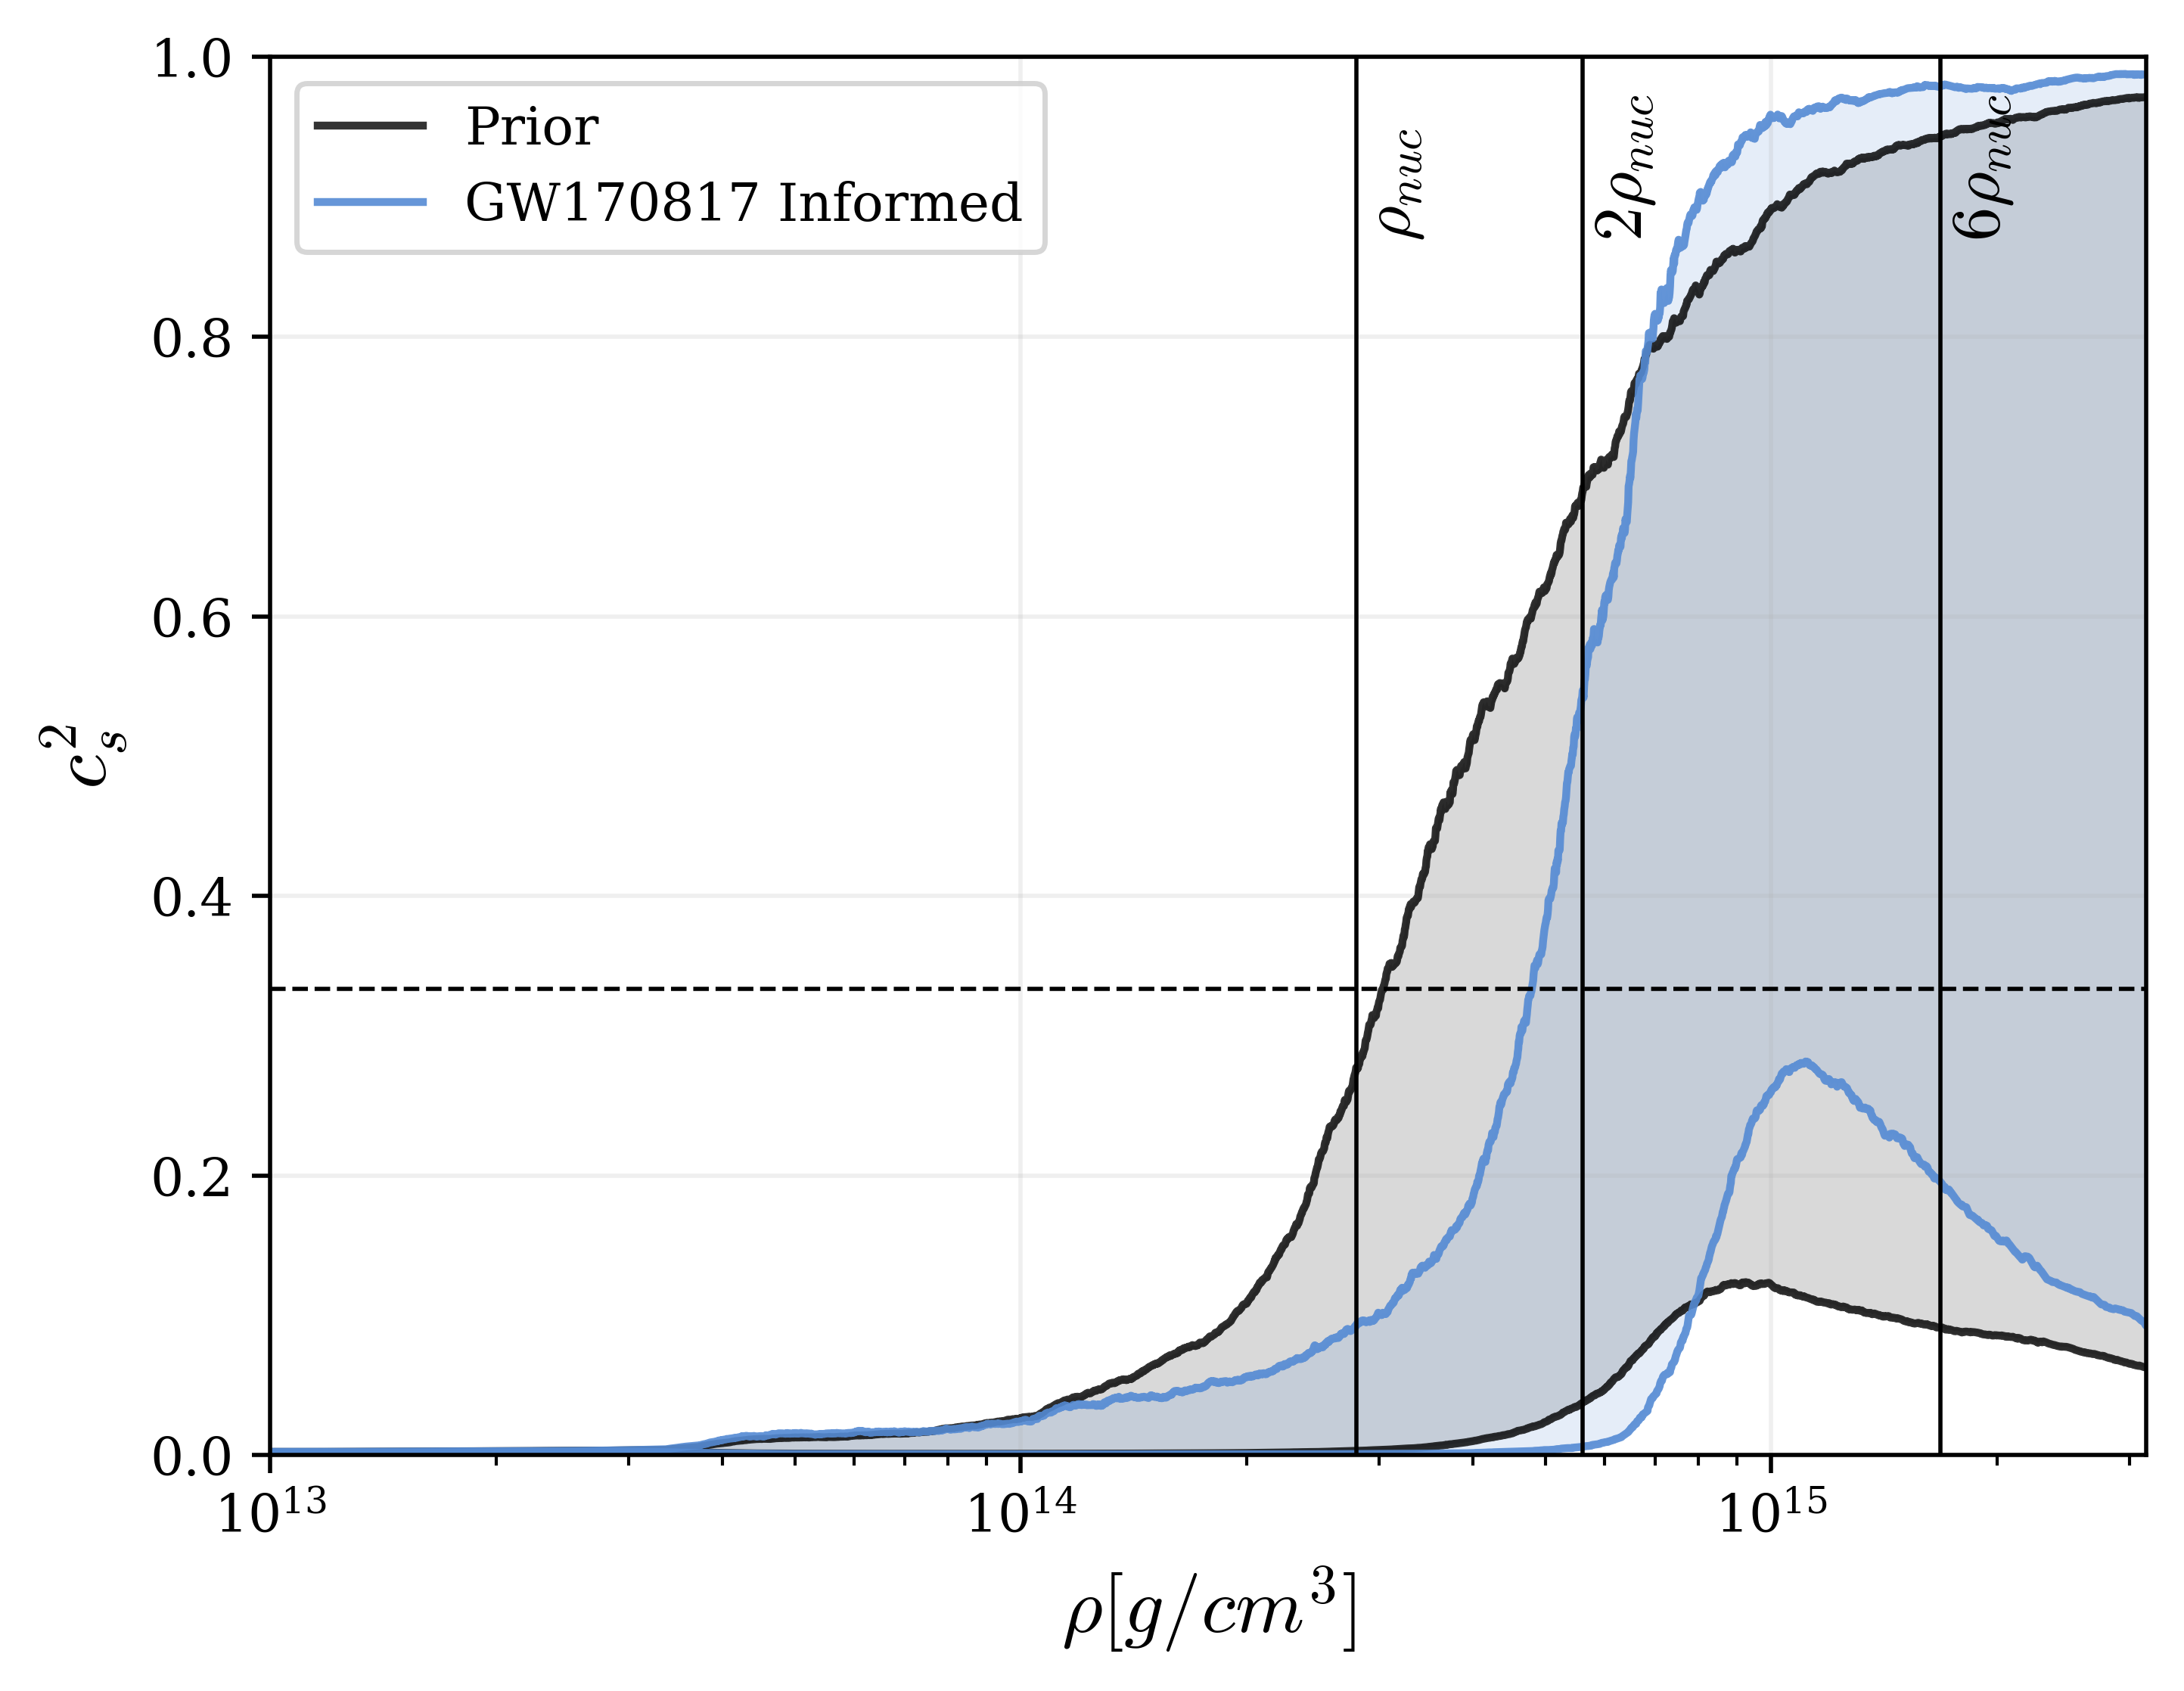

In [16]:
plt.semilogx()
plt.plot(plot_densities,sigmas[:,0], color = "k", alpha = .8, label = "Prior") 
plt.plot(plot_densities,sigmas[:,1], color = "k", alpha = .8)
plt.plot(plot_densities,w_sigmas[:,0], color = "#558BD4", alpha = .9, label = "GW170817 Informed") 
plt.plot(plot_densities,w_sigmas[:,1], color = "#558BD4", alpha = .9)
plt.fill_between(plot_densities,sigmas[:,0], sigmas[:,1], alpha = 0.15, color = "k")
plt.fill_between(plot_densities,w_sigmas[:,0], w_sigmas[:,1], alpha = 0.15, color = "#558BD4")


plt.xlabel(r"$\rho [g/cm^3]$", math_fontfamily = "cm", fontsize = 15.)
plt.ylabel(r"$c_{s}^{2}$", math_fontfamily="cm", fontsize = 15.)
plt.xlim(np.power(10.0,13.0), np.power(10.0, 15.5))
plt.ylim(0.0, 1.0)
plt.grid(alpha = 0.2)

plt.axhline(y = .33333, color = "k", linestyle = "--", linewidth = .8)
plt.axvline(x = sat_dens, color = "k", linewidth = .8)
plt.axvline(x = 2*sat_dens, color = "k", linewidth = .8)
plt.axvline(x = 6*sat_dens, color = "k", linewidth = .8)

plt.annotate(r"$\rho_{nuc}$",xy = ((sat_dens*(np.power(10.0,.005))), 0.88),
             rotation = 90.0, math_fontfamily = "cm", fontsize = 13.)
plt.annotate(r"$2\rho_{nuc}$",xy = ((2*sat_dens)*(np.power(10.0,.012)), 0.88),
             rotation = 90.0, math_fontfamily = "cm", fontsize = 13.)
plt.annotate(r"$6\rho_{nuc}$",xy = ((6*sat_dens)*(np.power(10.0,.012)), 0.88),
             rotation = 90.0, math_fontfamily = "cm", fontsize = 13.)

plt.legend()
plt.gcf().set_dpi(500)

plt.show()

***

### Loading GW170817 weights

In [59]:
lwp_run = True
verbose = True
gw_event = "GW170817"
eos_set = "Nonparam"

if lwp_run == True: ### To load weights from a condor-submitted LWP job
    weights = pd.read_csv(f"{gw_event}_{eos_set}_lwp/result/{gw_event}_{eos_set}_lwp_eos.csv")
elif lwp_run != True: ### To load weights from notebook analysis runs
    weights = pd.read_csv(f"{astro_prefix}_eos.csv") 
    if verbose == True:
        print(f"Loading weights for event: {astro_prefix}")
        
max_logweight = max(weights['logmargweight'])

### Number of effective samples in weighting:

In [35]:
Neff = ((sum(weights["logmargweight"]))**2)/(sum(weights["logmargweight"]**2))
print(f"Number of effective EoS's: {Neff}")

Number of effective EoS's: 64.22468668264129


## Trace Anomaly Calculations: For GW170817

In [36]:
plot_densities = np.geomspace(np.power(10.0,13.0), np.power(10.0,16.0), len(eos_to_be_used))
percentiles = [5,95]

In [37]:
tracevals = []
w_trvals = []
for eos in range(len(eos_to_be_used)):
    eos_densities = macro_data2[eos]["energy_densityc2"]
    eos_trace = trace_anom(macro_data2[eos]['pressurec2'], macro_data2[eos]["energy_densityc2"])
    tracevals.append(np.interp(plot_densities, eos_densities, eos_trace))
tracevals = np.array(tracevals)

for eos in weight_eos:
    eos_densities = macro_data2[eos]["energy_densityc2"]
    eos_tr = trace_anom(macro_data2[eos]['pressurec2'], macro_data2[eos]["energy_densityc2"])
    w_trvals.append(np.interp(plot_densities, eos_densities, eos_tr))
w_trvals = np.array(w_trvals)

### Obtaining quantiles 
tr_sigmas = np.zeros((len(plot_densities),len(percentiles)))
w_tr_sigmas = np.zeros((len(plot_densities),len(percentiles)))
for i in range(len(plot_densities)):
    tr_sigmas[i]=np.percentile(np.array(tracevals[:,i]),percentiles)
    w_tr_sigmas[i]=np.percentile(np.array(w_trvals[:,i]),percentiles)

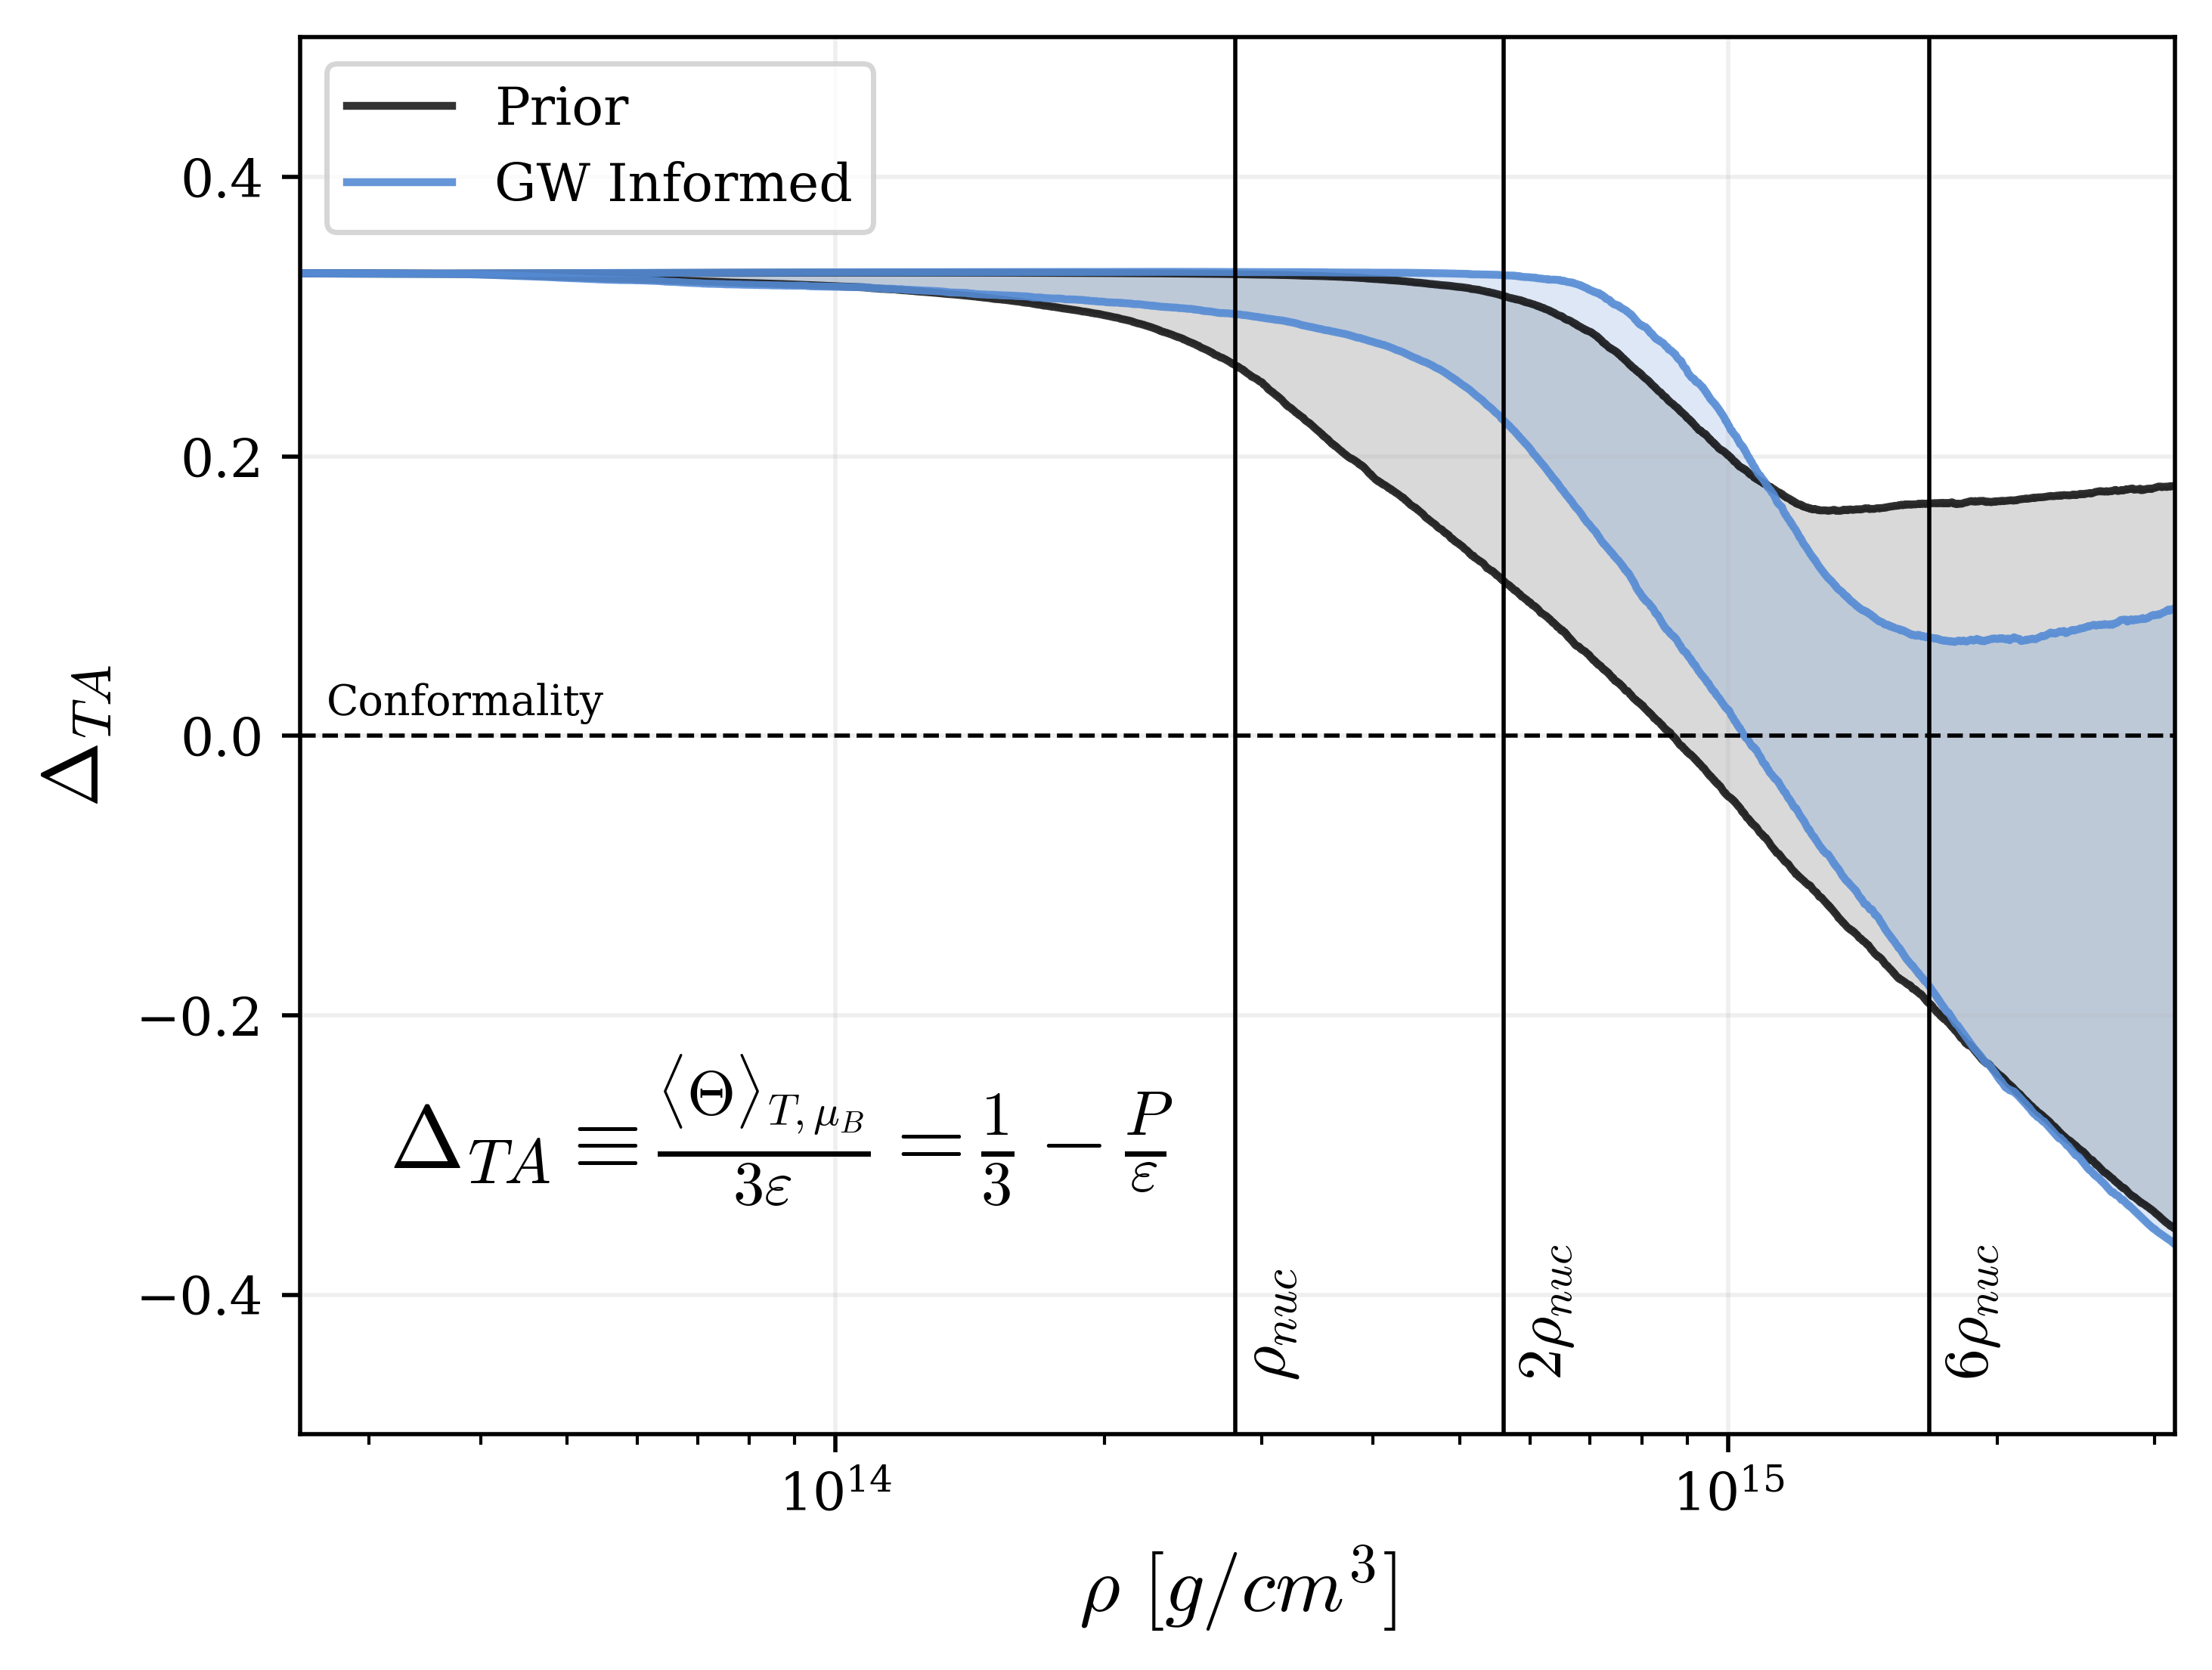

In [38]:
plt.semilogx()

plt.plot(plot_densities,tr_sigmas[:,0], color = "k", alpha = .8, label = "Prior") 
plt.plot(plot_densities,tr_sigmas[:,1], color = "k", alpha = .8)
plt.plot(plot_densities,w_tr_sigmas[:,0], color = "#558BD4", alpha = .9, label = "GW Informed") 
plt.plot(plot_densities,w_tr_sigmas[:,1], color = "#558BD4", alpha = .9)

plt.fill_between(plot_densities,tr_sigmas[:,0], tr_sigmas[:,1], alpha = 0.15, color = "k")
plt.fill_between(plot_densities,w_tr_sigmas[:,0], w_tr_sigmas[:,1], alpha = 0.2, color = "#558BD4")

plt.xlabel(r"$\rho \ [g/cm^3]$", math_fontfamily = "cm", fontsize = 15.)
plt.ylabel(r"$\Delta_{TA}$", math_fontfamily="cm", fontsize = 15.)

xmin = np.power(10.0,13.4)
xmax = np.power(10.0,15.5)

plt.xlim(xmin,xmax)
plt.ylim(-0.5, 0.5)
plt.grid(alpha = 0.2)

plt.axhline(y = 0.0, color = "k", linestyle = "--", linewidth = .8)
plt.axvline(x = sat_dens, color = "k", linewidth = .8)
plt.axvline(x = 2*sat_dens, color = "k", linewidth = .8)
plt.axvline(x = 6*sat_dens, color = "k", linewidth = .8)

plt.annotate(r"$\rho_{nuc}$",xy = ((sat_dens), -0.45),
             rotation = 90.0, math_fontfamily = "cm", fontsize = 13.)
plt.annotate(r"$2\rho_{nuc}$",xy = ((2*sat_dens)*(np.power(10.0,.012)), -0.45),
             rotation = 90.0, math_fontfamily = "cm", fontsize = 12.)
plt.annotate(r"$6\rho_{nuc}$",xy = ((6*sat_dens)*(np.power(10.0,.012)), -0.45),
             rotation = 90.0, math_fontfamily = "cm", fontsize = 12.)
plt.annotate(r"$\Delta_{TA} \equiv \frac{\langle\Theta\rangle_{T,\mu_B}}{3\varepsilon} = \frac{1}{3} - \frac{P}{\varepsilon}$",
             xy = ((np.power(10.0,13.5)), -0.31),
             math_fontfamily = "cm", fontsize = 17.)
plt.annotate("Conformality", xy = ((np.power(10.0,13.43)), .015),
             math_fontfamily = "cm", fontsize = 8.)

plt.legend()


plt.gcf().set_dpi(500)
#plt.savefig(f"Trace Anomaly Contour {astro_prefix}", dpi = 500)

plt.show()